# Center of Mass Check

Make sure the CM is located inside of the stability triangle created by the 3 (stationary) foot locations.

**Still a work in progress**

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm 
from math import sin, cos, pi, sqrt
from math import radians as d2r

In [3]:
def rot_z(t, c):
    """
    t - theta [radians]
    c - [x,y,z] or [x,y] ... the function detects 2D or 3D vector
    """
    if len(c) == 3:
        ans = np.array([
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ])
    else:
        ans = np.array([
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t)
        ])

    return ans

In [4]:
class RobotTransform(object):
    """
    Converts pts between the leg and body frame.
    """
    def __init__(self, radius):
        """
        in:
            radius - radius of body from CM in mm
            anglesB2L - angles to transform between body and leg frames
        """
        # cmrot
        self.leg2body = [pi/4, -pi/4, -3*pi/4, 3*pi/4]  # legs to body frame # orig
#         self.leg2body = [-pi/4, pi/4, 3*pi/4, -3*pi/4]  # legs to body frame
        # frame
        self.body2leg = [-pi/4, pi/4, 3*pi/4, -3*pi/4]  # body to leg frame # orig
#         self.body2leg = [pi/4, -pi/4, -3*pi/4, 3*pi/4]  # body to leg frame
        # account for base, in base frame
        cm = radius*cos(pi/4)
        self.base = [
            np.array([cm, cm, 0]),
            np.array([cm, -cm, 0]),
            np.array([-cm, -cm, 0]),
            np.array([-cm, cm, 0])
        ]
        
    def leg2Body(self, legNum, pts):
        """
        Converts points from leg_frame to body_frame
        """
        pts2 = rot_z(self.leg2body[legNum], pts) + self.base[legNum]
        return pts2
    
    def body2Leg(self, legNum, pts):
        """
        Converts points from body_frame to leg_frame
        """
        pts2 = rot_z(self.body2leg[legNum],pts-self.base[legNum])
        return pts2    

In [5]:
# Plotting routine for testing
def plotFeetxyz(feet, cfeet, correction):
    # account for base, in base frame
    tf = RobotTransform(45)
    opx = []  # original gait 
    opy = []
    cpx = []  # corrected gait
    cpy = []
    oxy = []  # double check
    cxy = []  # double check
    
    print('------------------------------------')
    print('Body frame')
    print('Correction: {:.2f} {:.2f}'.format(*correction[0:2]))

    def fill(ax, ay, feet):
        for p in feet:  # p = [index, legNum, (x,y,z)]
            index = p[0]
            legNum = p[1]
            foot = tf.leg2Body(legNum, p[2])
            if index > 2:  # check index to see if leg moving
                corr = foot + correction  # body frame for plotting
                ax.append(foot[0])
                ay.append(foot[1])
        return ax, ay
    
    opx, opy = fill(opx, opy, feet)
    cpx, cpy = fill(cpx, cpy, cfeet)
#     for p in feet:  # p = [index, legNum, (x,y,z)]
#         index = p[0]
#         legNum = p[1]
#         foot = tf.leg2Body(legNum, p[2])
#         if index > 2:  # check index to see if leg moving
#             corr = foot + correction  # body frame for plotting
#             opx.append(foot[0])
#             opy.append(foot[1])
#             cpx.append(corr[0])
#             cpy.append(corr[1])
#             oxy.append(foot[0:2])
#             cxy.append(corr[0:2])
#             print('Foot[{}]: Orig: {:.2f} {:.2f}  Corr: {:.2f} {:.2f}'.format(*(legNum, foot[0], foot[1], corr[0], corr[1])))

    plt.scatter([0], [0], c='g', label='CM')  # CM
    plt.scatter(opx, opy, c='r', label='Gait')  # gait
    plt.scatter(cpx, cpy, c='b', label='Corrected Gait')  # corrected gait
    plt.grid(True)
    plt.legend(loc='upper left');
    plt.xlabel('Corrected foot locations');

#     print('gait inside: {}'.format(Correction.inside(oxy)))
#     print('corrected gait inside: {}'.format(Correction.inside(cxy)))

In [27]:
class Correction(object):
    def __init__(self):
        pass
        
    @staticmethod
    def inside(feet, prnt=False):
        """
        Determine if a point P is inside of a triangle composed of points
        A, B, and C.
        pts = [A,B,C]
        P = [0,0] at the center of mass of the robot
        returns True (inside triangle) or False (outside the triangle)
        """
        pts = []
        for p in feet:
            if isinstance(p, np.ndarray):
                pts.append(p)
                
        # print('inSideCM pts:', pts)
        A = pts[0][0:2]
        B = pts[1][0:2]
        C = pts[2][0:2]
        P = np.array([0, 0])  # CM is at the center :)

        # Compute vectors
        v0 = C - A
        v1 = B - A
        v2 = P - A

        # Compute dot products
        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)

        # Compute barycentric coordinates
        invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * invDenom
        v = (dot00 * dot12 - dot01 * dot02) * invDenom

        if prnt:
            print(u, v)

        # Check if point is in triangle
        ans =((u >= 0) and (v >= 0) and (u + v < 1))
        
        print('inside():', ans)
        return ans

    @staticmethod
    def lineIntersection(p1, p2, p3):
        """
        Find the intersection of 2 lines.
        line 1: p1, p2
        line 2: p3, [0,0]
        """
        x1 = p1[0]
        x2 = p2[0]
        x3 = p3[0]
        x4 = 0.0
        y1 = p1[1]
        y2 = p2[1]
        y3 = p3[1]
        y4 = 0.0

        denom = ((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        if abs(denom) < 0.00001:
            # print('crap {}'.format(denom))
            return np.array([0, 0])
        x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/denom
        y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/denom
        return np.array([x, y])

    @staticmethod
    def vmin(a):
        """
        Find the minimum vector in an array of 2D vectors.
        in = [[1,2], [2,3], ...]
        out = [1,2]
        """
        minv = 0
        min_val = 1000000000000000
        for p in a:
            val = norm(p)
            if val < min_val:
                min_val = val
                minv = p
        return minv
    
    def correction(self, feet, movingFoot):
        """
        Given the robot's foot locations, provide correction if the
        center of mass (CM) is outside the triangle formed by the 3
        foot locations.
        pts = [foot0, foot1, foot2, foot3]
        correction = [x,y,0]
        """      
#         a = []
#         for i in range(0, 3):
#             p0 = pts[i]
#             p1 = pts[(i+1) % 3]
#             xx = self.lineIntersection(p0, p1, cm0, cm1)
#             a.append(xx)
#         a = self.vmin(a)
#         correction = np.array([-a[0], -a[1], 0.0])
        # 0 1 2 3
        op = feet[(movingFoot + 2)%4]
        p0 = feet[(movingFoot + 1)%4]
        p1 = feet[(movingFoot + 3)%4]
        a = self.lineIntersection(p0, p1, op)
        correction = np.array([-a[0], -a[1], 0.0])
        return correction
    
    def calcCorrection(self, feet):
        """
        This take the feet positions, calculated by a Gait, and adjusts them
        to ensure the CM is inside of the stability triangle.
        
        in:
            feet = [[index, legNum, foot], ...] there are 4 of these
                    index - tells if foot is up/down
                    legNum - which leg [0-3]
                    foot - (x,y,z) is converted to 2D
        out:
            correction = [x,y,0] is only a 2D correction
        """
        temp = [0,0,0,0]
        tf = RobotTransform(45)
        
        print('-------------------')
        print('calcCorrection()')
        movingLeg = 0
        for f in feet:
            index = f[0]
            foot = f[2]
            legNum = f[1]
            if index > 2:
                print('in foot: {:.2f} {:.2f}'.format(*foot[0:2]))
                ft = tf.leg2Body(legNum, foot)
                temp[legNum] = ft
                print('rotated foot: {:.2f} {:.2f}'.format(*ft[0:2]))
            else:
                movingFoot = legNum

        if not self.inside(temp):
            correction = 1.5*self.correction(temp, movingFoot)
        else:
            correction = np.array([0,0,0])
        return correction

    def rotateFeetCorrected(self, feet, correction):
        """
        return: [[index, legNum, (x,y,z)], ...] corrected stationary feet positions
        """
        tf = RobotTransform(45)
        ans = []
        for p in feet:  # p = [index, legNum, (x,y,z)]
            index = p[0]
            legNum = p[1]
            foot = p[2]
            if index > 2:  # check index to see if leg moving
                foot = tf.leg2Body(legNum, foot) + correction
                foot = tf.body2Leg(legNum, foot)
            ans.append([index, legNum, foot])
        return ans
    

-------------------
calcCorrection()
in foot: 34.00 -20.00
rotated foot: 70.00 41.72
in foot: 44.00 20.00
rotated foot: 77.07 -48.79
in foot: 14.00 50.00
rotated foot: -6.36 -77.07
inside(): False
corr foot: 22.05 33.16
corr foot: -9.16 8.05
corr foot: 25.95 -3.16
corr foot: 64.00 0.00
------------------------------------
Body frame
Correction: -46.04 29.14


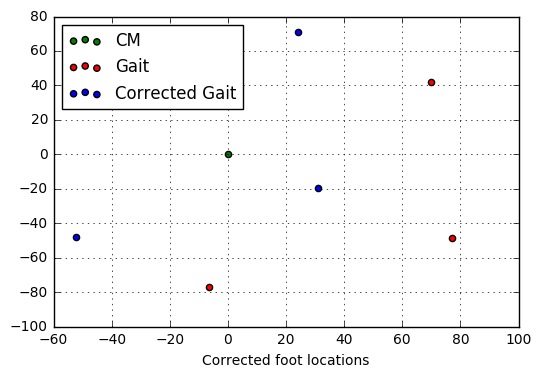

In [35]:
# These feet positions are produced by a Gait ... I am just 
# testing right now, so I made them up
# [index, legNum, (x,y,z)] <-- need to keep track of what Gait produced
feet = [
#     [3, 0, np.array([64,0.0,-65])],
#     [6, 1, np.array([34,20.0,-65])],
#     [9, 2, np.array([14,40.0,-65])],
#     [0, 3, np.array([64,0.0,-65])]  # this leg is moving, not involved in calcs 
#     [3, 0, np.array([64,0.0,-65])],
#     [6, 1, np.array([64,0.0,-65])],
#     [9, 2, np.array([64,0.0,-65])],
#     [0, 3, np.array([64,0.0,-65])]  # this leg is moving, not involved in calcs 
    [3, 0, np.array([34,-20.0,-65])],
    [6, 1, np.array([44,20.0,-65])],
    [9, 2, np.array([14,50.0,-65])],
    [0, 3, np.array([64,0.0,-65])]  # this leg is moving, not involved in calcs 
]

corr = Correction()
c = corr.calcCorrection(feet)
# print(feet[0][2])
cfeet = corr.rotateFeetCorrected(feet, c)  # put correction back into leg frame
for f in cfeet:
            print('corr foot: {:.2f} {:.2f}'.format(*f[2][0:2]))
plotFeetxyz(feet, cfeet, c)

In [22]:
isinstance(np.array([1,1]), np.ndarray)

True

In [19]:
type(4)

int

In [20]:
type(np.array([1,1]))

numpy.ndarray


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.